# Linear Models I

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [5]:
os.getcwd()

'/Users/cericia/Documents/CSIRO/core/05-simple-predictions/notebooks'

In [13]:
data_folder = path.join(path.abspath('..'), 'data')

In [14]:
pi2 = path.join(data_folder,'pi2','gnfuv-temp-exp1-55d487b85b-5g2xh_1.0.csv')
pi2

'/Users/cericia/Documents/CSIRO/core/05-simple-predictions/data/pi2/gnfuv-temp-exp1-55d487b85b-5g2xh_1.0.csv'

In [16]:
#https://archive.ics.uci.edu/ml/machine-learning-databases/00492/

## Data Transformations

Sometimes our data does not look strictly linear. In some cases, we can transform our data so that we can easily apply linear regression. To understand various transforms, we will create a data series.

In [122]:
x = np.arange(1,100).reshape(-1,1)
y = np.array([(i**2)+(10*i)*(np.sin(i)+1) for i in x]) # + np.random()
series = y

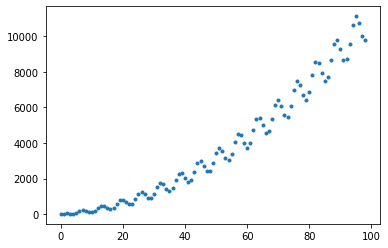

In [123]:
plt.plot(series,'.')
plt.show()

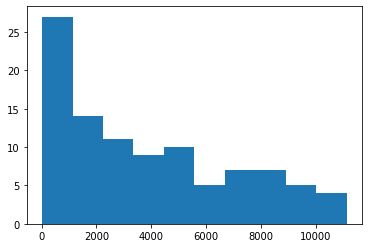

In [111]:
plt.hist(series)
plt.show()

Our data does not look strictly linear, but let's go ahead and fit a linear model

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=100)
model = LinearRegression() # y=m*x + b

In [128]:
model.fit(x_train, y_train)

0.9725412895121122

In [160]:
print("R^2: ",model.score(x_test, y_test))
print("Slope: ", model.coef_)
print("Intercept: ", model.intercept_)

R^2:  0.9725412895121122
Slope:  [[109.01964507]]
Intercept:  [-1628.60455011]


Text(0.5, 1.0, 'Residuals')

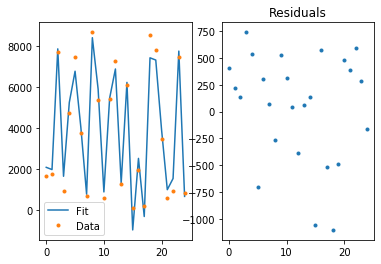

In [152]:
pred_test = model.predict(x_test)
res_test = pred_test - y_test

plt.subplot(121)
plt.plot(pred_test,label='Fit')
plt.plot(y_test,'.',label='Data')
plt.legend()
plt.subplot(122)
plt.plot(res_test,'.')
plt.title("Residuals")

That looks pretty good! And the coefficient of determiniation is close to 1. Looks like we have a nice model. Let's plot the model for all of the input data (x).

Text(0.5, 1.0, 'Residuals')

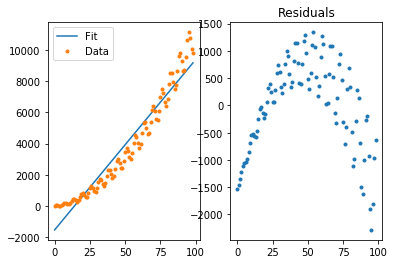

In [153]:
pred = model.predict(x)
res = pred - y

plt.subplot(121)
plt.plot(pred,label='Fit')
plt.plot(y,'.',label='Data')
plt.legend()
plt.subplot(122)
plt.plot(res,'.')
plt.title("Residuals")

Wow! Look at those residuals. I don't think the model we have obtained is great.

### Square Root Transform

We can take the square root of our data

In [83]:
transform_sqrt = np.sqrt(series)

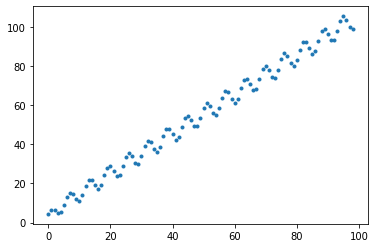

In [85]:
# line plot
plt.plot(transform_sqrt,'.')
plt.show()


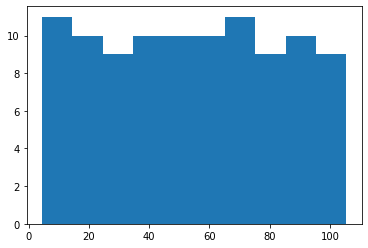

In [86]:
# histogram
plt.hist(transform_sqrt)
plt.show()

In [76]:
s2 = [np.sin(i)+1 for i in range(0,100)]

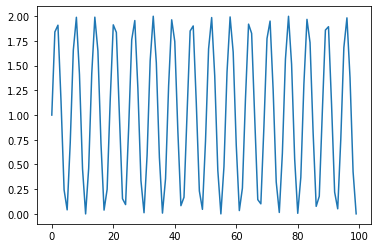

In [77]:
plt.plot(s2)